### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

Cloning into 'cv_project'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 519 (delta 82), reused 168 (delta 47), pack-reused 278
Receiving objects: 100% (519/519), 97.11 MiB | 37.89 MiB/s, done.
Resolving deltas: 100% (228/228), done.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=16310 sha256=8b35ea992cd3b4e785161f8a12fc21e0bb21cb420c493cc2ad8b50804ee9eacf
  Stored in directory: /tmp/pip-ephem-wheel-cache-e6vey2ia/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [5]:
pip install stellargraph

     |████████████████████████████████| 440kB 15.9MB/s 


In [6]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import VehiculesFixedSizeImageLoader
from src.data.dataset_loaders import VehiculesDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage, EqualHist
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.evaluation import validate_model, precision, recall, f1_score

# Vehicules
# ResNet50
# Pipeline: EqualHist, Norm

### Load dataset

In [7]:
DATA_PATH = DRIVE_PATH+'data/processed/vehicules/resnet/data_resnet_eqhist.pickle'

In [8]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet50

In [9]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 5

In [10]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))


model.compile(
    optimizer=K.optimizers.Adam(0.001),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

94674944/94668760 [==============================] - 0s 0us/step
Epoch 1/5
43/43 [==============================] - 13s 94ms/step - loss: 0.4197 - accuracy: 0.8923 - val_loss: 0.1305 - val_accuracy: 0.9852
Epoch 2/5
43/43 [==============================] - 2s 47ms/step - loss: 0.0609 - accuracy: 0.9914 - val_loss: 0.2305 - val_accuracy: 0.9555
Epoch 3/5
43/43 [==============================] - 2s 47ms/step - loss: 0.0310 - accuracy: 0.9924 - val_loss: 0.0884 - val_accuracy: 0.9809
Epoch 4/5
43/43 [==============================] - 2s 48ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0711 - val_accuracy: 0.9894
Epoch 5/5
43/43 [==============================] - 2s 48ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0835 - val_accuracy: 0.9894


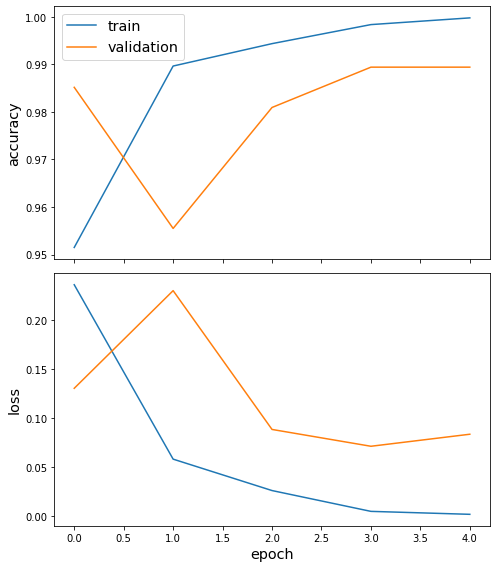

In [11]:
plot_history(history)

### Validation

In [12]:
del data

In [13]:
BND_BOX_SIZE = (50, 50)
STEP_SIZE = 20

dataset_loader = VehiculesDatasetLoader(
    image_loader=VehiculesFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        EqualHist(),
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

treshold = 0.9; nms_overlap=0.4

In [14]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/vehicules/eqhist/t9nms4',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:06<00:53,  6.72s/it]

202


 22%|██▏       | 2/9 [00:11<00:43,  6.16s/it]

230


 33%|███▎      | 3/9 [00:16<00:34,  5.75s/it]

65


 44%|████▍     | 4/9 [00:21<00:27,  5.48s/it]

61


 56%|█████▌    | 5/9 [00:26<00:21,  5.28s/it]

204
140


 78%|███████▊  | 7/9 [00:57<00:19,  9.75s/it]

242


 89%|████████▉ | 8/9 [01:02<00:08,  8.30s/it]

221


100%|██████████| 9/9 [01:07<00:00,  7.53s/it]

153



Precision: 0.219
Recall: 0.841
F1Score: 0.348
